# Machine Learning (Neural Network) Basics
## Part II: Neural Networks (Basic Structure)

This notebook is meant to give a brief introduction to the ideas behind machine learning and how they work.

An excellent web-site for playing with simple examples is [playground.tensorflow.org](https://playground.tensorflow.org/).

First we will check to see that all relevant packages have been installed.

In [1]:
# install packages if they're not already
import sys
sys.path.append("figs/")
import os
print ("Using anaconda environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
!conda install --yes --prefix {sys.prefix} -c numpy scipy matplotlib \
    pandas scikit-learn scikit-learn-intelex pytorch

Using anaconda environment: pygnn
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
# we typically always use numpy, pandas and matplotlib, so import those
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import pytorch
import torch
# determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Neural Networks (Basic Structure)

Neural networks are essentially fitters, but they are non-linear so they are much more flexible than other methods -- they even allow us the ability of solving non-trivial situations (like the two enclosed blobs example in the previous notebook).  

The neural network can take this two dimensional space, and project it into higher dimensions, allowing us to cut through it with hyperplanes that will allow us to simultaneously grab both of those isolated signal regions as we will see later.  

Before we show how this works, we will first explore the basic theory behind an artificial neural net.

#### Neurons (nodes)
--------------------

The basic object of any network is the neuron (or node).  The node is just an object that holds a number and is connected to other nodes throughout the network.

<p align="center">
    <img src="figs/node.png">
</p>

In this case we have a network with a single input node and a single output node.  It essentially does a nonlinear coordinate transformation which is given by the function

\begin{equation}
x_{\mathrm{out}} = \tanh\left(\omega\cdot x_{\mathrm{in}}\right)
\end{equation}

Where $\omega$ is a tunable parameter called a 'weight' and the function $\tanh(\omega\cdot x_{\mathrm{in}})$ is called the  'activation function.'  

In general we can pick all sorts of different activation functions, but for very simple binary classification problems the $\tanh()$ is sufficient.  This is because it is monotonic and bounded from -1.0 to 1.0.  Therefore we want to tune the network to give us outputs of 1.0 when we give it inputs of one class and -1.0 when we give it inputs of the other class.  

A network of this type doesn't do much for us out of the box, as we can see from the following example.

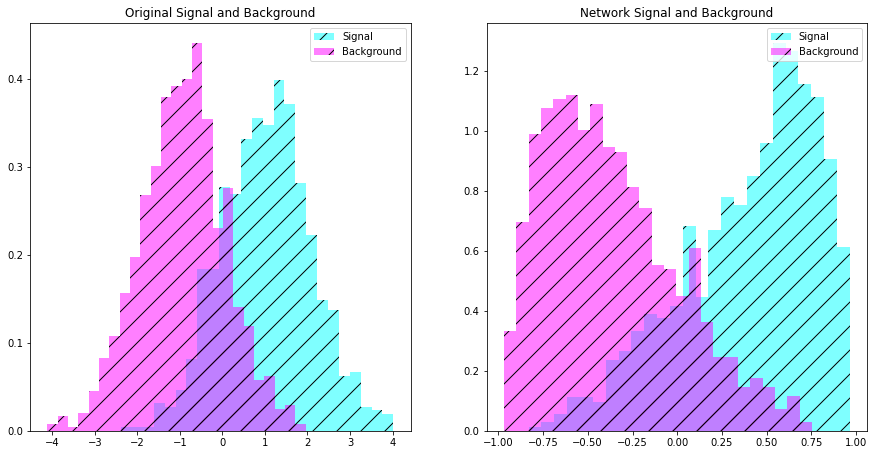

In [5]:
"""
Generate signal/background data which consist
of two 1D Gaussian distributions with sigma=1.0
and a difference in mu=2.0.
"""
from ml_helpers import plot_simple_network_results
# We'll make some fake signal and background data, 
# and then run it through our single node network.
# We'll see that the network doesn't do much.
signal_in = np.random.normal(1.0,1.0,1000)
background_in = np.random.normal(-1.0,1.0,1000)
# choose a weight 
omega = 0.5
# apply the neural network transformation
signal_out = np.tanh(omega * signal_in)
background_out = np.tanh(omega * background_in)

# Now to plot the before and after
plot_simple_network_results(
    signal_in,
    background_in,
    signal_out,
    background_out
)

#### A more complex network
---------------------------

The network transformation doesn't do much, mostly because we are only doing a coordinate transformation when we map from one variable to another. Let's make the network a little more complex and see what happens.

<p align="center">
    <img src="figs/node2.png">
</p>

Here we have introduced a new feature, the hidden layer of the network.  This hidden layer has two nodes and is connected to both the input and the output nodes through a set of weights.  Labeling the hidden layers by $x_1$ and $x_2$ we can write their values based on the inputs as

$$
\begin{align}
x_1 = \tanh(\omega_1\cdot x_{\mathrm{in}})\\
x_2 = \tanh(\omega_2\cdot x_{\mathrm{in}})
\end{align}
$$

The difference from before comes with the output, which now has two inputs.  The way we write the value of the output is the activation function evaluated on the sum of the inputs, thus we have

$$
\begin{align}
x_{\mathrm{out}} &= \tanh\left(\sum_{i=1}^N\omega_{i}\cdot x_i\right)\\ 
&= \tanh\left(\omega_{\mathrm{out},1}\cdot x_1 + \omega_{\mathrm{out},2}\cdot x_2\right)\\
&= \tanh\left(\omega_{\mathrm{out},1}\cdot \tanh(\omega_1\cdot x_{\mathrm{in}}) + \omega_{\mathrm{out},2}\cdot \tanh(\omega_2\cdot x_{\mathrm{in}})\right)
\end{align}
$$

This seems like a strange thing to do, but it allows us to fit a hyperplane to the data by transforming the data space in a non-linear way which stretches the space and even projects it into higher dimensions.  

This particular network has four tunable parameters; $\omega_1, \omega_2, \omega_{\mathrm{out},1}$ and $\omega_{\mathrm{out},2}$ which are what we need to adjust based on the particular problem we are looking at.  By adjusting these parameters, we are adjusting the function $x_{\mathrm{out}} = f(x_{\mathrm{in}})$ so that it gives us the best guess about which class each of the $x_{\mathrm{in}}$ belong to.  The output of the function is the 'score' of the network and is analogous to the likelihood score I had mentioned in the beginning.  The neural network then allows us to skip the step of generating a probability distribution of the data which is essentially what the neural network is infering when it 'learns' about the problem.  

Before I explain how we get the network to learn a distribution, I'll go over some more of the basic details on structure.


## Multi-Layer Perceptron (MLP)
### Fully Connected (Feed Forward)
----------------------------------

The two example networks in the previous section are what we would call **fully connected**.  What this means is that every node in one layer is connected to every node in another layer.  

I should back up a bit and explain what I mean by a layer.  In deciding on how we should organize nodes, a simple and intuitive way is to group them in layers.  A sequence of layers is merely a one-dimensional stacking where the inputs are fed into the first layer and the outputs are then fed to the next layer and so on.  When we analyze a data, we look at one event at a time by first passing it to the input layer (which in the case of the previous network was a single node) and then move on to the next layer passing the output $(x^i_{\mathrm{in}})$ to each of the nodes of the next layer and multiplying by the relative weights.  Each of the nodes in that layer is then sent through the activation function and passed onto the next layer, and so on.

<p align="center">
    <img src="figs/node3.png">
</p>

So the feed-forward aspect is just a way of saying the network has an implicit directionality to it.  The next few diagrams show the explicit calculations of the inputs and outputs for this network which has one *'hidden'* layer.

<p align="center">
    <img src="figs/node4.png">
</p>

First the input $x_{\mathrm{in}}$ is sent to the input node.  Then the input is forwarded to each node in the hidden layer:

<p align="center">
    <img src="figs/node5.png">
</p>

The values are given by the activation function evaluated on the weights for each connection times the input:

<p align="center">
    <img src="figs/node6.png">
</p>

Finally the output is given by the activation function evaluated on the sum of all of its inputs times the relative weight factor  𝜔𝑙  for each node connected to it.

### Weights, Activation Functions, Biases
-----------------------------------------

All I've shown so far is situations where the activation function is a $\tanh()$ function, but this isn't the only option we could use.  There are a family of activation functions which have a set of desirable properties for the purposes of training a network.  These properties include the following:

**Continuously Differentiable** - This is important if we want to be able to use calculus for training the network. 

**Bounded Domains** - If the purpose of using a network is to get a 'score' for the output it's a good idea to have it be bounded so that the network doesn't push its output values off to inifinity.  

**Monotonically Increasing** - This is just so our outputs rank transitively.  If the functions we're not monotonic, then the network wouldn't be able to learn much since the domain would be a mixture of classes.

**Non-Linear** - This isn't a necessary requirement in general, but it allows for the estimation of a general function when there are at least two hidden layers which aren't linear.

The **continuously differentiable** constraint is entirely necessary for training methods that use a gradient descent algorithm since the adjustments to the weights come from derivative terms of the activation function as we will see.  You could imagine a network that trains using a stochastic mechanism, but I won't discuss that here.  As it stands the $\tanh()$ function has a nice derivative which is usually approximated to second order;

$$
\begin{equation}
\frac{\partial}{\partial x}\left(\tanh(x)\right)_{x'} \approx 1 - x^{'2}
\end{equation}
$$

Other useful activation functions include;

**Logistic** - $f(x) = \frac{1}{1 + e^{-x}}$

**Inverse Tangent** - $f(x) = \tan^{-1}(x)$

**Soft Sign** - $f(x) = \frac{x}{1 + |x|}$

Which all have outputs that look like the following

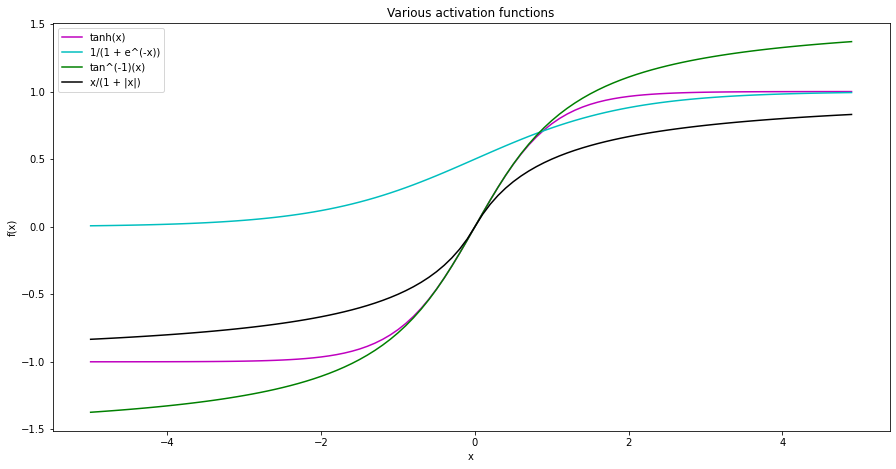

In [11]:
# . Generating some data in one variable 'x', and then generating the function outputs
x = np.arange(-5,5,0.1)
tanh = np.tanh(x)
logistic = 1 / (1 + np.exp(-x))
inverse_tan = np.arctan(x)
soft_sign = x / (1 + np.abs(x))
# Now we'll plot the function outputs as a function of the variable 'x'
fig, axs = plt.subplots(figsize=(15,7.5))
axs.plot(x,tanh,color='m',label='tanh(x)')
axs.plot(x,logistic,color='c',label='1/(1 + e^(-x))')
axs.plot(x,inverse_tan,color='g',label='tan^(-1)(x)')
axs.plot(x,soft_sign,color='k',label='x/(1 + |x|)')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("Various activation functions")
plt.legend()
plt.show()

### Rectified Linear (ReLU) and Leaky-ReLU
------------------------------------------
These all look pretty much the same, and so either of them are good candidates for activation functions.  Other types of classification problems may be better suited with piece-wise activation functions, such as **Rectified Linear** which is given by

$$
\begin{equation}
f(x) = \left\{\begin{matrix} 0,\quad x < 0\\ x,\quad x \geq 0 \end{matrix}\right.
\end{equation}
$$

which is discontinuous near zero.  This type of activation is useful for multi-class problems where the inputs and outputs are discrete (such as hand-drawn digit image recognition).  This would involve trying to classify hand-drawn digits which are discretized as binary pixels.

The discretized imagine is made of an $N$ number of pixels, each of which will now act as an input to a neural network.  Since we have more than two classes now, we have to decide what to do with the output.  We could still use a continuous single variable output and split it up according to the 10 possible answers, but an easier method would be to use more than one output.  In this case we would have ten outputs and use a rectified linear activation function.  

<p align="center">
    <img src="figs/digit_network.png">
</p>

Training this type of network will result in each output node obtaining some value which could be large depending on the type of network.  The guess at the answer is then whichever output has the highest value, and the training pushes each output node to infinity.  This would be something like:

### Soft-Max
------------

Another type of activation method is to normalize the outputs in each layer.  We can do this by assigning an exponential activation function for each output and then divide by the sum of them, which is similar to a canonical distribution.  Each activation is given by $e^x$ but all of the outputs in each layer is weighted by the partition function for that layer, thus we have

$$
\begin{equation}
f(x)_i = \frac{\exp[x_i]}{\sum_j \exp[x_j]}
\end{equation}
$$

This is what's known as the **Soft Max** activation function and is widely used.  

### Bias nodes
--------------

The last thing to address in this section is what's known as the bias node.  In general we must add to each layer a parameter which does not depend on the input from that layer, but is a constant node with its own weight.  This is called a bias node which allows us to perform a general linear transformation of the inputs.  For a simple network, adding biases leads to

$$
\begin{equation}
y = \tanh\left(\sum_i \omega_i\cdot x_i + \tilde{\omega}\right)
\end{equation}
$$

where $\tilde{\omega} = \omega_{\mathrm{bias}}\cdot 1$ is the bias parameter which always recieves an input of one.  Our network then gets modified to look like:

<p align="center">
    <img src="figs/net_bias.png">
</p>

The reason for these biases is to add an additional shift to the value of the input values which is independent of the $x$'s.  You can think of this as moving the y-intercept of a discrimiating line, where the weights rotate the line but the bias terms translate the line.